In [1]:
%reload_ext autoreload
%autoreload 2

# NumPy
import numpy as np

# torch
import torch
from torch.autograd import grad

# Misc.
from tqdm.auto import tqdm

from src import models

# user-defined libs.
from src.problems.solver import ODESolver
from src.utils import seed_everything
from src.utils.plotting import Artist

# Reproducibility
seed_everything()
# Set Device(CPU / GPU)
torch.set_float32_matmul_precision("high")
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch is using {torch.cuda.get_device_name(device)}")
# Metadata
log_dir = "logs"
task = "oscillator"

torch is using NVIDIA RTX A4000


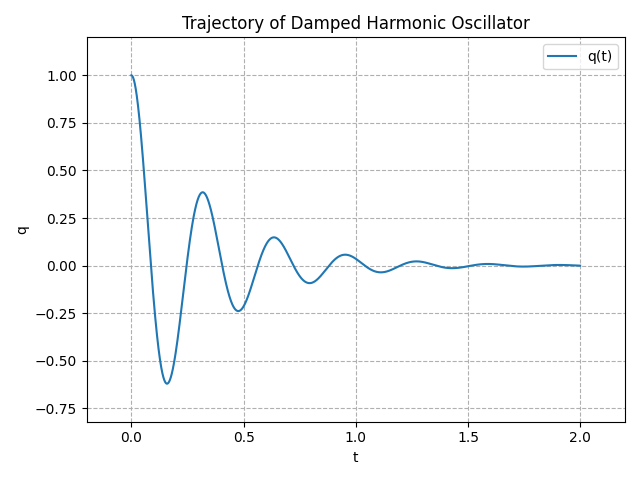

In [12]:
# Parameters
zeta: float = 0.15
omega0: float = 20.00

# Create an instance of ODESolver
# Problem: (Damped) Simple Harmonic Oscillator
solver = ODESolver(
    equation="sho",
    params=(zeta, omega0),
    trange=(0, 10),
    Nt=10000,
)

# Define an example initial condition
initial_condition = [1, 0]

# Solve the ODE using solve_ivp
solution = solver.solve_ivp(initial_condition)

solution = solution.T[:, 0]
ts = solver.ts

artist = Artist()
artist.plot_ode(ts, solution)
artist.show()

## Pure MLP

In [13]:
model = models.MLP(
    input_dim=1,
    hidden_dim=20,
    output_dim=1,
    num_layers=8,
    activation="gelu",
    linear_output=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()


# Train data
# train_data = torch.Tensor(ts[0:200:20]).view(-1, 1).to(device)
# train_target = torch.Tensor(solution[0:200:20]).view(-1, 1).to(device)
train_data = torch.Tensor(ts).view(-1, 1).to(device)
train_target = torch.Tensor(solution).view(-1, 1).to(device)

# Test data
test_data = torch.Tensor(ts).view(-1, 1).to(device)
test_target = torch.Tensor(solution)

total_step = 1_000
plot_interval = 10
model_name = "DNN"
model_log = f"{log_dir}/{model_name}/{task}"

model.train()
for step in tqdm(range(total_step)):
    optimizer.zero_grad()
    preds = model(train_data)
    loss = criterion(preds, train_target)
    loss.backward()
    optimizer.step()

    if (step + 1) % plot_interval == 0:
        artist.plot_ode(
            test_data.cpu().squeeze(),
            test_target,
            model(test_data).detach().cpu().squeeze(),
            f"{model_name} / Training Step: {step+1:04d}, Loss:{loss.item():.3f}",
            # xp=[train_data.detach().cpu(), train_target.detach().cpu(), "Training Data"],
        )
        artist.save_img(f"step_{step+1:05d}", f"{model_log}/imgs")
artist.save_gif_from_files(f"{model_name}-{task}", model_log)

100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s]


## Physics-Informed Neural Networks

In [4]:
model = models.MLP(
    input_dim=1,
    hidden_dim=20,
    output_dim=1,
    num_layers=8,
    activation="gelu",
    linear_output=True,
).to(device)
adam = torch.optim.Adam(model.parameters(), lr=1e-4)
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50_000,
    max_eval=50_000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe",
)
criterion = torch.nn.MSELoss()


# Train data
train_data = torch.Tensor(ts[0:200:20]).view(-1, 1).to(device)
train_target = torch.Tensor(solution[0:200:20]).view(-1, 1).to(device)

# Test data
test_data = torch.Tensor(ts).view(-1, 1).to(device)
test_target = torch.Tensor(solution)

# Collocation data
pinn_data = torch.Tensor(ts).view(-1, 1).to(device)


def pinn_loss(model, t, weight: float = 1):
    # ddx = -2ζω * dx -ω^2 * x
    t = t.requires_grad_()
    x = model(t)
    dx = grad(x, t, torch.ones_like(x), create_graph=True)[0]
    ddx = grad(dx, t, torch.ones_like(dx), create_graph=True)[0]
    return weight * criterion(ddx, -2 * zeta * omega0 * dx - (omega0**2) * x)


def closure():
    lbfgs.zero_grad()
    preds = model(train_data)
    loss_d = criterion(preds, train_target)
    loss_g = pinn_loss(model, pinn_data)
    loss = loss_d + loss_g
    loss.backward()
    return loss


total_step = 10_000
plot_interval = 100
model_name = "PINN"
model_log = f"{log_dir}/{model_name}/{task}"

model.train()
for step in tqdm(range(total_step)):
    adam.zero_grad()
    preds = model(train_data)
    # data-driven loss
    loss_d = criterion(preds, train_target)
    # pinn loss
    loss_g = pinn_loss(model, pinn_data)
    # total loss
    loss = loss_d + loss_g
    loss.backward()
    adam.step()

    if (step + 1) == int(total_step * 0.90):
        lbfgs.step(closure)

    if (step + 1) % plot_interval == 0:
        artist.plot_ode(
            test_data.cpu().squeeze(),
            test_target,
            model(test_data).detach().cpu().squeeze(),
            f"{model_name} / Training Step: {step+1:04d}, Loss:{loss.item():.3f}",
            xp=[train_data.detach().cpu(), train_target.detach().cpu(), "Training Data"],
        )
        artist.save_img(f"step_{step+1:05d}", f"{model_log}/imgs")
artist.save_gif_from_files(f"{model_name}-{task}", model_log)

  0%|          | 1/10000 [00:00<17:03,  9.77it/s]

100%|██████████| 10000/10000 [03:25<00:00, 48.61it/s]
